# CNN for Bottle Label Defects Classification

This model is to build a CNN model that can classify bottle label based on their differences: without wrinkle or with wrinkle, using transfer learning method based on ResNet50. 
   

This structure is based on keras computer vision example.

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. For instance, features from a model that has learned to identify racoons may be useful to kick-start a model meant to identify tanukis.

Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.

The most common incarnation of transfer learning in the context of deep learning is the following worfklow:

Take layers from a previously trained model.
Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
Train the new layers on your dataset.

In [ ]:
"""
# This will prompt for authorization.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'CS231N_Final_Project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the COCO dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME
"""

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
# freeze the layers

options = 3

if options == 1:
  layer = keras.layers.Dense(3)
  layer.build((None, 4))  # Create the weights
elif options == 2:
  layer = keras.layers.BatchNormalization()
  layer.build((None, 4))  # Create the weights
else:
  layer = keras.layers.Dense(3)
  layer.build((None, 4))  # Create the weights
  layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


In [ ]:
# freeze the layers
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
#model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])
model = keras.Sequential([keras.layers.InputLayer(input_shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)


In [ ]:
# recursive setting of the traiable attribute
inner_model = keras.Sequential(
    [
        #keras.Input(shape=(3,)),
        keras.layers.InputLayer(input_shape=(3,)),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(3, activation="relu"),
    ]
)

model = keras.Sequential(
    #[keras.Input(shape=(3,)), inner_model, keras.layers.Dense(3, activation="sigmoid"),]
    [keras.layers.InputLayer(input_shape=(3,)), inner_model, keras.layers.Dense(3, activation="sigmoid"),]
)

model.trainable = False  # Freeze the outer model

assert inner_model.trainable == False  # All layers in `model` are now frozen
assert inner_model.layers[0].trainable == False  # `trainable` is propagated recursively


In [ ]:
# instantiate a base model with pretrained weights
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.


In [ ]:
# then freeze the base model
base_model.trainable = False


In [ ]:
# create a new model on top
inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


In [ ]:

# generate a dataset
image_size = (150, 150) # this is 
batch_size = 32

new_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "WrinkleImages1",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "WrinkleImages1",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "testTrans",
    validation_split=0.5,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

In [ ]:
# train the model on new data
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)


In [ ]:
# FINE TUNING

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

#implement fine-tuning of the whole base model
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
#model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)
model.fit(new_dataset, epochs=5, callbacks=callbacks, validation_data=val_dataset,)

Epoch 1/5
13/13 [==============================] - 83s 2s/step - loss: 0.9955 - binary_accuracy: 0.7050 - val_loss: 0.1780 - val_binary_accuracy: 0.8800


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
13/13 [==============================] - 4s 246ms/step - loss: 0.2220 - binary_accuracy: 0.8875 - val_loss: 0.1634 - val_binary_accuracy: 0.9600
Epoch 3/5
13/13 [==============================] - 4s 255ms/step - loss: 0.1263 - binary_accuracy: 0.9550 - val_loss: 0.0671 - val_binary_accuracy: 0.9800
Epoch 4/5
13/13 [==============================] - 4s 254ms/step - loss: 0.0710 - binary_accuracy: 0.9800 - val_loss: 0.0532 - val_binary_accuracy: 0.9900
Epoch 5/5
13/13 [==============================] - 4s 249ms/step - loss: 0.0424 - binary_accuracy: 0.9950 - val_loss: 0.0555 - val_binary_accuracy: 0.9900


In [ ]:
# transfer learning & fine-tuning wiht a custom training loop
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

# Create new model on top.
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()

# Iterate over the batches of a dataset.
for inputs, targets in new_dataset:
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        predictions = model(inputs)
        # Compute the loss value for this batch.
        loss_value = loss_fn(targets, predictions)

    # Get gradients of loss wrt the *trainable* weights.
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))


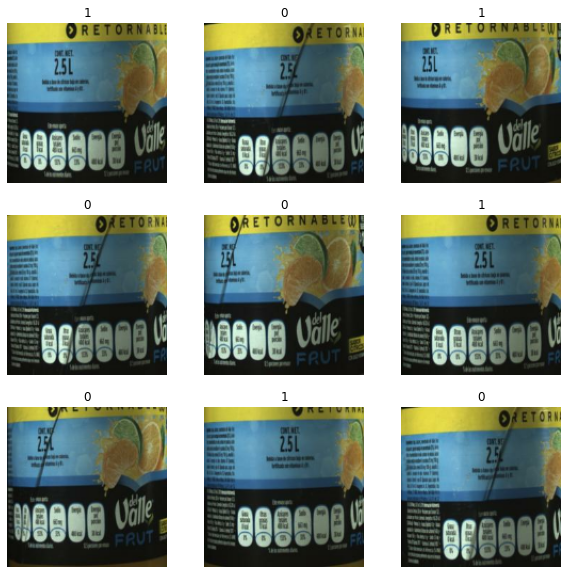

In [ ]:
# visually display data
import matplotlib.pyplot as plt

#plt.figure(figsize=(10, 10))
#for i, (image, label) in enumerate(new_dataset.take(9)): # train_ds
#    ax = plt.subplot(3, 3, i + 1)
#    plt.imshow(image)
#    plt.title(int(label))
#    plt.axis("off")

plt.figure(figsize=(10, 10))
for images, labels in new_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.imshow(images[1][1])
        plt.title(int(labels[i]))
        #plt.title(labels[train[0][1]])
        plt.axis("off")

In [ ]:
# resize image to 150x150
size = (150, 150)

train_ds = new_dataset.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = val_dataset.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_dataset.map(lambda x, y: (tf.image.resize(x, size), y))


In [ ]:
# use batching and caching to optimize loading speed
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

#print("train_ds:", train_ds.shape)

In [ ]:
# using random data augmentation
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


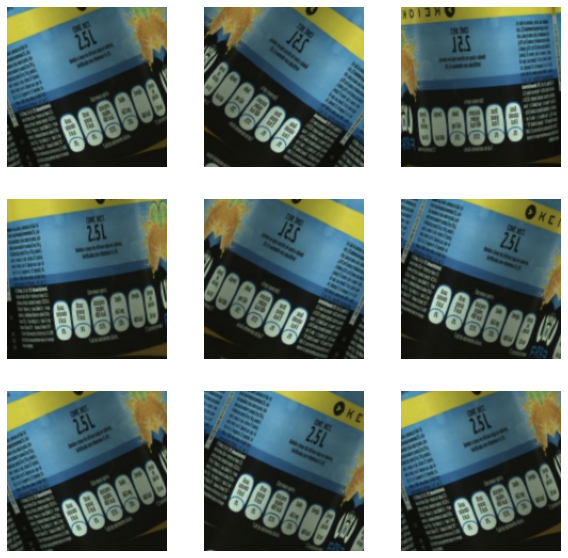

In [ ]:
# visualize
import numpy as np
"""
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")
"""
# visualize the augmentation
plt.figure(figsize=(10, 10))
for images, _ in new_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# BUILD A MODEL
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 2049

In [ ]:
# train the top layer
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)


In [ ]:
# DO A ROUND OF FINE-TUNING OF THE ENTIRE MODEL

# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)
